In [1]:
#downloading a library for splitting dataset
!pip install split-folders

In [2]:
#importing libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import splitfolders
import os
import shutil
import glob
from PIL import Image, ImageFilter
from scipy.ndimage import gaussian_filter

In [3]:
#unzipping dataset
!unzip '/content/drive/MyDrive/Noise Encoding DL/dataset.zip' -d '/content/images'

Archive:  /content/drive/MyDrive/Noise Encoding DL/archive.zip
  inflating: /content/images/data/bike/bike_001.bmp  
  inflating: /content/images/data/bike/bike_002.bmp  
  inflating: /content/images/data/bike/bike_003.bmp  
  inflating: /content/images/data/bike/bike_004.bmp  
  inflating: /content/images/data/bike/bike_005.bmp  
  inflating: /content/images/data/bike/bike_006.bmp  
  inflating: /content/images/data/bike/bike_007.bmp  
  inflating: /content/images/data/bike/bike_008.bmp  
  inflating: /content/images/data/bike/bike_009.bmp  
  inflating: /content/images/data/bike/bike_010.bmp  
  inflating: /content/images/data/bike/bike_011.bmp  
  inflating: /content/images/data/bike/bike_012.bmp  
  inflating: /content/images/data/bike/bike_013.bmp  
  inflating: /content/images/data/bike/bike_014.bmp  
  inflating: /content/images/data/bike/bike_015.bmp  
  inflating: /content/images/data/bike/bike_016.bmp  
  inflating: /content/images/data/bike/bike_017.bmp  
  inflating: /conte

In [4]:
#splitting dataset into train, validation and test datasets (validation and test will be merged in this case)
path = "/content/images/data"
splitfolders.ratio(path,seed=1337, output="Images-Splitted", ratio=(0.6, 0.2, 0.2))

Copying files: 1803 files [00:03, 518.39 files/s]


In [6]:
#creating folders for datasets
os.mkdir('data')
os.mkdir('data/train')
os.mkdir('data/train/images')
os.mkdir('data/valid')
os.mkdir('data/valid/images')

In [7]:
#copying images from one directory to another
dst_directory = '/content/data/train/images'
for folder in os.listdir('/content/Images-Splitted/train'):
  src_directory = f'/content/Images-Splitted/train/{folder}'
  for file in os.listdir(src_directory):
    src_file = os.path.join(src_directory, file)
    dest_file = os.path.join(dst_directory, file)
    shutil.move(src_file, dest_file)

In [8]:
dst_directory = '/content/data/valid/images'
for folder in os.listdir('/content/Images-Splitted/val'):
  src_directory = f'/content/Images-Splitted/val/{folder}'
  for file in os.listdir(src_directory):
    src_file = os.path.join(src_directory, file)
    dest_file = os.path.join(dst_directory, file)
    shutil.move(src_file, dest_file)

In [9]:
dst_directory = '/content/data/valid/images'
for folder in os.listdir('/content/Images-Splitted/test'):
  src_directory = f'/content/Images-Splitted/test/{folder}'
  for file in os.listdir(src_directory):
    src_file = os.path.join(src_directory, file)
    dest_file = os.path.join(dst_directory, file)
    shutil.move(src_file, dest_file)

In [11]:
#creating data generator and using this from reading images from directories
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
datagen_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data = datagen_train.flow_from_directory(
    '/content/data/train/',
    target_size=(256, 256),  # Resizes images to (256, 256)
    batch_size=32,
    class_mode=None,
    shuffle=False)

test_data = datagen_valid.flow_from_directory(
    '/content/data/valid/',
    target_size=(256, 256),  # Resizes images to (256, 256)
    batch_size=32,
    class_mode=None,
    shuffle=False)

Found 1081 images belonging to 1 classes.
Found 722 images belonging to 1 classes.


In [12]:
#creating a function to add noise to images
def add_noise(images):
    noise_factor = 0.01
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return noisy_images

In [13]:
#creating a function to make images blur
def add_blur(images):
  for index, image in enumerate(images):
    blured_image = gaussian_filter(image, sigma=(3,3,0))
    images[index] = blured_image
  return images

In [14]:
#concatinating images
x_train = np.concatenate([train_data[i] for i in range(len(train_data))])
x_valid = np.concatenate([test_data[i] for i in range(len(test_data))])

In [15]:
#appliying noise function to imahes
x_train_noisy = add_noise(x_train)
x_valid_noisy = add_noise(x_valid)

In [17]:
#appliying blur function to imahes
x_train_noisy = add_blur(x_train_noisy)
x_valid_noisy = add_blur(x_valid_noisy)

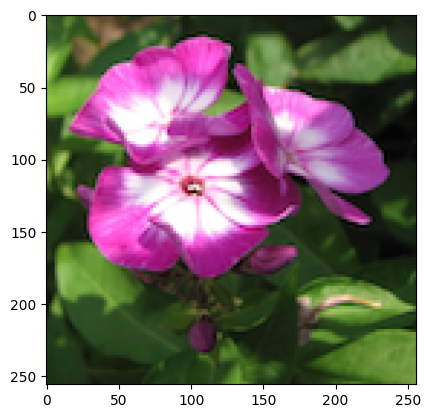

In [18]:
plt.imshow(x_valid[3])

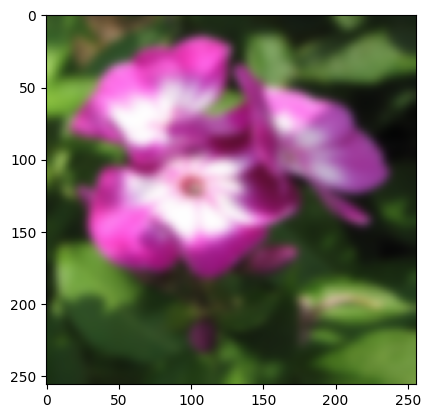

In [19]:
plt.imshow(x_valid_noisy[3])

In [20]:
# creating encoder and decoder
input_shape = tf.keras.Input((256, 256, 3))
x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_shape)
x1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x1)
x2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x2)
x3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
x3 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x3)

# Bottleneck
encoded = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x3)

x4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x4 = tf.keras.layers.UpSampling2D((2, 2))(x4)
x5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x4)
x5 = tf.keras.layers.UpSampling2D((2, 2))(x5)
x6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x5)
x6 = tf.keras.layers.UpSampling2D((2, 2))(x6)
decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x6)

autoencoder = tf.keras.Model(input_shape, decoded) # making the model


In [21]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       295168

In [22]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
#adding callback to the model which help to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [24]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_valid_noisy, x_valid),
    callbacks=[early_stopping])

Epoch 1/50
34/34 [==============================] - 62s 1s/step - loss: 0.0543 - val_loss: 0.0286
Epoch 2/50
34/34 [==============================] - 13s 397ms/step - loss: 0.0209 - val_loss: 0.0182
Epoch 3/50
34/34 [==============================] - 14s 401ms/step - loss: 0.0150 - val_loss: 0.0124
Epoch 4/50
34/34 [==============================] - 14s 404ms/step - loss: 0.0109 - val_loss: 0.0098
Epoch 5/50
34/34 [==============================] - 14s 407ms/step - loss: 0.0093 - val_loss: 0.0086
Epoch 6/50
34/34 [==============================] - 14s 400ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 7/50
34/34 [==============================] - 14s 401ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 8/50
34/34 [==============================] - 14s 400ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 9/50
34/34 [==============================] - 14s 403ms/step - loss: 0.0071 - val_loss: 0.0098
Epoch 10/50
34/34 [==============================] - 14s 404ms/step - loss: 0.0079 - val_loss:

In [72]:
# testing the model with a random picture from the Internet
test_image =cv2.imread('blur_person.jpeg')

In [73]:
test_image_resized = cv2.resize(test_image, (256, 256))

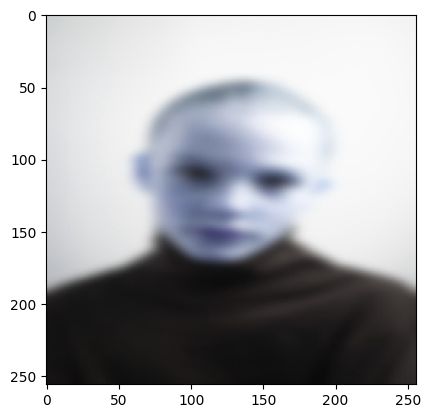

In [74]:
plt.imshow(test_image_resized)

In [75]:
img_array = test_image_resized / 255.0  # Normalize the image
img_array = np.expand_dims(img_array, axis=0)

In [77]:
predicted_image = autoencoder.predict(img_array)[0]

1/1 [==============================] - 0s 27ms/step


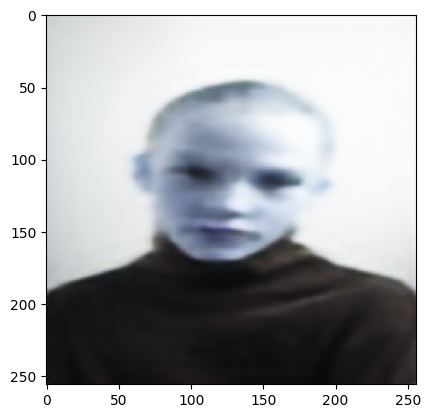

In [79]:
#prediction of the model
plt.imshow(predicted_image)